# Chicago Car Crashes Exploration
Authors: Lenore Perconti, Jakub Rybicki, Noble Tang

Flatiron Data Science School, Phase Three Project

10/28/21

## Overview

In this project we looked at traffic incident data from the City of Chicago. We joined two data sets, processed them, and used modeling to infer information on traffic incidents at night. 

### Business Understanding

Our stakeholder is City of Chicago Department of Transportation. They are interested in learning more about what factors contribute to severe traffic incidents for drivers at night.

* **Severe** traffic incidents we defined as `FATAL` or `INCAPACITATING` from the `INJURY_TYPE` column.

* **Night** we defined as the hours between 10pm to 5 am, or hours 22 through 5 in the `CRASH_HOUR` column.

## Data Understanding and Cleaning
The data used was sourced from the following websites:

https://data.cityofchicago.org/Transportation/Traffic-Crashes-Crashes/85ca-t3if

https://data.cityofchicago.org/Transportation/Traffic-Crashes-People/u6pd-qa9d

The data was downloaded on Friday, October 22. Attempts to reproduce this notebook may result in inconcistancies since the online source is updated weekly.

These datasets are include very recent data and information from 2013 to present. The number of variables and columns in this dataset made it challenging to clean and use, however the broad scope of the data makes it a good candidate for exploring the business problem at hand.

The large size of the original datasets were too large to upload to github, we create a cleaned and merged dataset below that is included in the dataset.

In [37]:
#Importing the neccessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, f1_score, roc_auc_score
from sklearn.metrics import roc_curve, classification_report, plot_roc_curve
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from imblearn.pipeline import Pipeline as imb_Pipeline

In [38]:
crash_df = pd.read_csv('data/Traffic_Crashes_-_crashes.csv')
people_df = pd.read_csv('data/Traffic_Crashes_-_people.csv', low_memory=False)

### Dropping Unneccessary Columns
`Crash_df` dropping Justification:

* `RD_NO` - Police Dep. Report number, another identifying number associated with each record, we kept CRASH_RECORD_ID as the joining record number for each dataframe.
* `CRASH_DATE_EST_I` - used when crash is reported to police days after the crash, this dataframe inclues crash day of week, hour and month so we can drop the specific date.
* `CRASH_DATE` - this dataframe inclues crash day of week, hour and month so we can drop the specific date.
* `REPORT_TYPE` - administrative report type, not a factor relevant to causing a crash.
* `HIT_AND_RUN_I` - not a factor relevant to causing a crash.
* `DATE_POLICE_NOTIFIED` - not a factor relevant to causing a crash.
* `BEAT_OF_OCCURENCE` - not a factor relevant to causing a crash.
* `PHOTOS_TAKEN_I` - not a factor relevant to causing a crash.
* `STATEMENTS_TAKEN` - not a factor relevant to causing a crash. 
* `LANE_COUNT` - Dropping lane count because we found too many null values that we don't want to skew data with mean/median, and don't want to assume a distribution for synthetic data

Basing our severity of injury off of information from the people_df dataframe, including this and other injury related columns would cause multicolliniarity in our modeling.
* `MOST_SEVERE_INJURY` -
* `INJURIES_FATAL`
* `INJURIES_NON_INCAPACITATING`
* `INJURIES_REPORTED_NOT_EVIDENT`
* `INJURIES_NO_INDICATION`
* `INJURIES_UNKNOWN`

Location related info we dropped - not enough time for the scope of this project
* `LONGITUDE`
* `LATITUDE`
* `STREET_NO`

In [39]:
crash_df_cleaned = crash_df[['CRASH_RECORD_ID', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION', 
                             'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND', 
                             'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH']]

### `people_df` dropping dustification:

* `PERSON_ID` - unique ID for each person record, will use CRASH_RECORD_ID
* `RD_NO` - Police Dep. Report number, another identifying number associated with each record, we kept CRASH_RECORD_ID as the joining record number for each dataframe.
* `VEHICLE_ID` - another indentifying factor we don't need
* `CRASH_DATE` - time records coming from crash.csv dataset
* `SEAT_NO` - too small representation .09% of dataset 

Location info not looked into:
* `CITY`
* `STATE`
* `ZIPCODE`


* `SEX` - not relevant to causing a crash
* `DRIVER_LICENCE_STATE` - not a factor relevant
* `DRIVER_LICENCE_CLASS` - not a factor relevant
* `SAFETY_EQUIPMENT` - included safety equipment worn by pedestrians, cyclists, etc. would have been too time consuming to wade through.
* `AIRBAG_DEPLOYED`- not a factor relevant
* `EJECTION` not a factor relevant

Hospital and EMS info not relevant to learning about causes of crash: 
* `HOSPITAL` 
* `EMS_AGENCY`
* `EMS_RUN_NO`


* `DRIVER_VISION` - 40% of data is unknown vision. Hard to make assumptions fairly
* `PHYSICAL_CONDITION` - condition of the driver after the accident does not play a role in causation
* `PEDPEDAL_ACTION` - action of a pedestrian varies between instances. Holds no info that city could change
* `PEDPEDAL_VISIBILITY` - clothing of the pedestrian holds no info that city could enforce
* `PEDPEDAL_LOCATION` - location of the pedestrian at time of crash holds no info that city could enforce
* `CELL_PHONE_USE` - not enough data to utlize

In [40]:
people_df_cleaned = people_df[['CRASH_RECORD_ID', 'AGE', 
                               'BAC_RESULT VALUE', 'INJURY_CLASSIFICATION', 'PERSON_TYPE']]

#### Getting only incidents that occured at night: 
Night = between 10 pm and 6 am, these are the nighttime hours defined by licencing. 

In [41]:
night_time_df = crash_df_cleaned.copy()
night_time_df = night_time_df[(night_time_df['CRASH_HOUR'] >= 22) | (night_time_df['CRASH_HOUR'] <= 6)]
night_time_df.columns

Index(['CRASH_RECORD_ID', 'TRAFFIC_CONTROL_DEVICE', 'DEVICE_CONDITION',
       'WEATHER_CONDITION', 'LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND',
       'CRASH_HOUR', 'CRASH_DAY_OF_WEEK', 'CRASH_MONTH'],
      dtype='object')

## Joining the two data sets

In [42]:
#checking the shape
night_time_df.shape, people_df_cleaned.shape

((93448, 9), (1224613, 5))

In [43]:
merge = pd.merge(night_time_df, people_df_cleaned, how='left', on='CRASH_RECORD_ID')
merge.shape

(188733, 13)

In [44]:
#no longer need Crash ID - not useful for modeling
merge = merge.drop(columns=['CRASH_RECORD_ID'])

### Exploring Columns Further

**Target Variable:** `INJURY_CLASSIFICATION`
* This includes all people involved in incident, cyclists, passengers, drivers, etc. 

In [45]:
#taking a look at Injury Classification
merge['INJURY_CLASSIFICATION'].value_counts()

NO INDICATION OF INJURY     166735
NONINCAPACITATING INJURY     12730
REPORTED, NOT EVIDENT         5501
INCAPACITATING INJURY         2834
FATAL                          310
Name: INJURY_CLASSIFICATION, dtype: int64

In [46]:
#Making Injury Classification into a binary to indicate "serious" incidents
# fatal and incapacitate = 1
merge.loc[(merge['INJURY_CLASSIFICATION'] == 'FATAL') | 
           (merge['INJURY_CLASSIFICATION'] == 'INCAPACITATING INJURY') | 
           (merge['INJURY_CLASSIFICATION'] == 'NONINCAPACITATING INJURY') |
           (merge['INJURY_CLASSIFICATION'] == 'REPORTED, NOT EVIDENT'), 'INJURY_CLASSIFICATION'] = 1

# else = 0
merge.loc[(merge['INJURY_CLASSIFICATION'] == 'NO INDICATION OF INJURY'), 'INJURY_CLASSIFICATION'] = 0

merge['INJURY_CLASSIFICATION'].fillna(0, inplace=True)

In [47]:
#normalizing Injury Classification
merge["INJURY_CLASSIFICATION"].value_counts(normalize=True)

0    0.886745
1    0.113255
Name: INJURY_CLASSIFICATION, dtype: float64

### Traffic control device

Transforming traffic control device into a new column, 0 for no control device or a malfunctioning device, 1 for control device functioning properly

In [48]:
merge.loc[merge['TRAFFIC_CONTROL_DEVICE'] == 'NO CONTROLS', 'TRAFFIC_CONTROL_DEVICE'] = 0
merge.loc[merge['TRAFFIC_CONTROL_DEVICE'] != 0, 'TRAFFIC_CONTROL_DEVICE'] = 1

merge.loc[merge.DEVICE_CONDITION == 'FUNCTIONING PROPERLY', 'DEVICE_CONDITION'] = 1
merge.loc[merge.DEVICE_CONDITION != 1, 'DEVICE_CONDITION'] = 0

merge['DEVICE_CONDITION'] = merge['DEVICE_CONDITION'].astype(float)
merge['TRAFFIC_CONTROL_DEVICE'] = merge['TRAFFIC_CONTROL_DEVICE'].astype(float)

####  Weather

* categorized 1 as clear weather, rest as 0 for unfavorable weather

In [49]:
# 1 is clear
merge.loc[merge['WEATHER_CONDITION'] == 'CLEAR', 'WEATHER_CONDITION'] = 1

# 0 is not clear
merge.loc[merge['WEATHER_CONDITION'] != 1, 'WEATHER_CONDITION'] = 0

merge['WEATHER_CONDITION'] = merge['WEATHER_CONDITION'].astype(float)

####  Roadway Surface Condition

* Binned `OTHER` with `UNKNOWN`

In [50]:
merge.loc[merge['ROADWAY_SURFACE_COND'] == 'OTHER', 'ROADWAY_SURFACE_COND'] = 'UNKNOWN'

In [51]:
merge['ROADWAY_SURFACE_COND'].value_counts()

DRY                135461
WET                 31526
UNKNOWN             13430
SNOW OR SLUSH        6527
ICE                  1712
SAND, MUD, DIRT        77
Name: ROADWAY_SURFACE_COND, dtype: int64

#### Age

`AGE` had a lot of outliers including some negative ages and zeros which likely were typos. To limit these outliers we dropped them. 

In [52]:
merge.loc[merge['AGE'] <= 0, 'AGE'] = None

In [53]:
merge.dropna(subset=['AGE'], inplace=True)

#### Driver

Limited dataset to just show `PERSON_TYPE` = `DRIVER`. Pedestrians, cyclists and other people types would not have influence over a car crash as much as a driver would. 

In [54]:
merge = merge.loc[merge['PERSON_TYPE'] == 'DRIVER']

In [55]:
merge.drop(columns=['PERSON_TYPE'], inplace=True)

#### Blood Alcohol Content

For this column we binned the data into 1 = over the legal limit (.08) and 0 = under the limit.

In [56]:
merge['BAC_RESULT VALUE'].fillna(0, inplace=True)

# 1 is drunk
merge.loc[merge['BAC_RESULT VALUE'] >= 0.08, 'BAC_RESULT VALUE'] = 1

# 0 is not drunk
merge.loc[merge['BAC_RESULT VALUE'] < 0.08, 'BAC_RESULT VALUE'] = 0

#### Day of week


Binned weekends and weekdays, we saw in the histogram crashes occured on weekends more than weekdays. 

<BarContainer object of 7 artists>

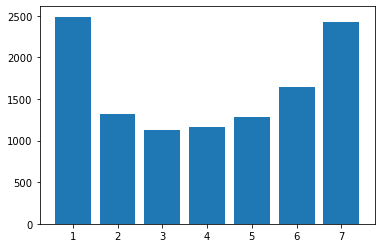

In [57]:
#Plotting for the presentation to show Day of Week crashes
injury_df = merge.copy()

injury_df = injury_df.loc[injury_df['INJURY_CLASSIFICATION'] == 1]

fig, ax = plt.subplots()

ax.bar(list(injury_df['CRASH_DAY_OF_WEEK'].value_counts().index), 
       injury_df['CRASH_DAY_OF_WEEK'].value_counts().values)

In [58]:
# binning weekends and weekday nights

# 1 value is a weekend night
merge.loc[merge['CRASH_DAY_OF_WEEK'] >= 6, 'CRASH_DAY_OF_WEEK'] = 1

# 0 value is a weekday night
merge.loc[merge['CRASH_DAY_OF_WEEK'] != 1, 'CRASH_DAY_OF_WEEK'] = 0

### Compile Final DF

Exporting the `final_df` into csv file

In [59]:
final_df = merge.copy()
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 95484 entries, 3 to 188727
Data columns (total 11 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   TRAFFIC_CONTROL_DEVICE  95484 non-null  float64
 1   DEVICE_CONDITION        95484 non-null  float64
 2   WEATHER_CONDITION       95484 non-null  float64
 3   LIGHTING_CONDITION      95484 non-null  object 
 4   ROADWAY_SURFACE_COND    95484 non-null  object 
 5   CRASH_HOUR              95484 non-null  int64  
 6   CRASH_DAY_OF_WEEK       95484 non-null  int64  
 7   CRASH_MONTH             95484 non-null  int64  
 8   AGE                     95484 non-null  float64
 9   BAC_RESULT VALUE        95484 non-null  float64
 10  INJURY_CLASSIFICATION   95484 non-null  int64  
dtypes: float64(5), int64(4), object(2)
memory usage: 8.7+ MB


In [60]:
#This is where the clean_data.csv is created and can be found in the github. 
#clean_data = final_df.to_csv('clean_data.csv', index = False)

# Modeling

For all our models we built a pipeline that accomplished the following: 
* Column Transformers One Hot Encoded categorical columns
* Used SMOTE strategy to synthesize new examples for the minority class and address class imbalance
* Perform a grid search to find optimal 

## First Model

#### Smote Oversampling + Decision Tree

This model shows a tree that helps us find the features that we are interested in

In [61]:
#Split our data into X and Y, test and train samples. 
X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [62]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
#under = RandomUnderSampler(sampling_strategy=0.5)

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('classifier', DecisionTreeClassifier(random_state=11))
])

In [63]:
param_grid = [{'classifier__max_depth':[1, 3, 5]}]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted = grid_search.best_score_
test_score_smoted = grid_search.score(X_test, y_test)

In [64]:
cv_score_smoted, test_score_smoted

(0.6643019631973515, 0.7046656542912499)

In [65]:
confusion_matrix(y_pred, y_test)

array([[12773,  1606],
       [ 4034,   684]])

## Baseline Model
A baseline model helps us find the features we are most interested in and where we can focus modeling iterations on to get better models. 

SMOTE logistic regression with just traffic control device (picked from our tree above). This is the simplest model to give us a place to start.

In [72]:
X = final_df[['TRAFFIC_CONTROL_DEVICE']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [73]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
#    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [74]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [75]:
cv_score_smoted_log, test_score_smoted_log

(0.4659954764913203, 0.46756034979316125)

In [76]:
confusion_matrix(y_pred, y_test)

array([[7582,  943],
       [9225, 1347]])

In [77]:
roc_auc_score(y_pred, y_test)

0.5083980980024699

#### Logsitic Regression Baseline Discussion: 
Our ROC score is barely better than random chance (0.508). That's ok though, this gives us a baseline! 

## Model 2.5 
SMOTE logistic regression with all features. 

This is our attempt to improve on the baseline model

In [78]:
X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [79]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [80]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [95]:
print('Logistic regression, all features:')
print(f'cv score: {cv_score_smoted_log} and test score {test_score_smoted_log}')
print(f'confusion matrix: {confusion_matrix(y_pred, y_test)}')
print(f'ROC Accuracy Score: {roc_auc_score(y_pred, y_test)}')
print(f'Classification Report:')
print(classification_report(y_pred, y_test))

Logistic regression, all features:
cv score: 0.526319976015973 and test score 0.5187725820809551
confusion matrix: [[8535  918]
 [8272 1372]]
ROC Accuracy Score: 0.5225762962808908
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.90      0.65      9453
           1       0.60      0.14      0.23      9644

    accuracy                           0.52     19097
   macro avg       0.55      0.52      0.44     19097
weighted avg       0.55      0.52      0.44     19097



#### SMOTE logistic regression: all features Discussion: 

Our accuracy is slightly better than the baseline with just one feature. We'd still like to see something better.


## Model 3: smote knn
This model uses all the features in the final_df. would produce favorable results but needs tuning

In [96]:
X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [97]:
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train,
                                          random_state=42,
                                          test_size=0.2)

In [98]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('knn_classifier', KNeighborsClassifier())
])

In [99]:
param_grid = [{'knn_classifier__n_neighbors': [3,5,9,12,15],
               'knn_classifier__metric': ['minkowski','manhattan']}]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_t, y_t)

y_hat = grid_search.predict(X_val)
print(grid_search.best_params_)
cv_score_smoted_knn = grid_search.best_score_
test_score_smoted_knn = grid_search.score(X_test, y_test)

{'knn_classifier__metric': 'manhattan', 'knn_classifier__n_neighbors': 3}


In [100]:
print('Logistic regression, all features:')
print(f'cv score: {cv_score_smoted_knn} and test score {test_score_smoted_knn}')
print(f'confusion matrix: {confusion_matrix(y_pred, y_test)}')
print(f'ROC Accuracy Score: {roc_auc_score(y_pred, y_test)}')
print(f'Classification Report:')
print(classification_report(y_pred, y_test))

Logistic regression, all features:
cv score: 0.7708520443689837 and test score 0.7752526574854689
confusion matrix: [[8535  918]
 [8272 1372]]
ROC Accuracy Score: 0.5225762962808908
Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.90      0.65      9453
           1       0.60      0.14      0.23      9644

    accuracy                           0.52     19097
   macro avg       0.55      0.52      0.44     19097
weighted avg       0.55      0.52      0.44     19097



#### Model 3 Discussion: 
This model could produce favorable results but needs tuning

## Model 4: smote knn selective
This model uses the features determined by the decision tree from ‘smote oversampling’ to produce the best outcome

In [101]:
X = final_df.drop(columns=['INJURY_CLASSIFICATION', 'BAC_RESULT VALUE', 'AGE', 'CRASH_MONTH', 'CRASH_HOUR',
                          'TRAFFIC_CONTROL_DEVICE'])
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [102]:
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train,
                                          random_state=42,
                                          test_size=0.2)

In [103]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('knn_classifier', KNeighborsClassifier())
])

In [104]:
param_grid = [{'knn_classifier__n_neighbors': [3,5,9,12,15],
               'knn_classifier__metric': ['minkowski','manhattan']}]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_t, y_t)

y_hat = grid_search.predict(X_val)
print(grid_search.best_params_)
cv_score_smoted_knn = grid_search.best_score_
test_score_smoted_knn = grid_search.score(X_test, y_test)

KeyboardInterrupt: 

In [ ]:
print('Logistic regression, all features:')
print(f'cv score: {cv_score_smoted_knn} and test score {test_score_smoted_knn}')
print(f'confusion matrix: {confusion_matrix(y_pred, y_test)}')
print(f'ROC Accuracy Score: {roc_auc_score(y_pred, y_test)}')
print(f'Classification Report:')
print(classification_report(y_pred, y_test))

# Discussion and Conclusion


### smote over and undersampling

** is this model #1 ??? ** 

In [68]:
X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [69]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('classifier', DecisionTreeClassifier(random_state=11))
])

In [70]:
param_grid = [{'classifier__max_depth':[1, 3, 5]}]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print(grid_search.best_params_)
cv_score_smoted = grid_search.best_score_
test_score_smoted = grid_search.score(X_test, y_test)

{'classifier__max_depth': 5}


In [ ]:
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('classifier', DecisionTreeClassifier(random_state=11, max_depth=5))
])

fig, ax = plt.subplots(figsize=(40, 40))

pipeline.fit(X_train, y_train)
feature_list = pipeline['col_transformer'].get_feature_names()
plot_tree(pipeline['classifier'], ax=ax, feature_names=feature_list)

In [ ]:
cv_score_smoted, test_score_smoted

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
roc_auc_score(y_pred, y_test)

### no smote

In [ ]:
X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline as imb_Pipeline

# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

# Create a pipeline containing the column transformer and model
pipeline = Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('classifier', DecisionTreeClassifier(random_state=11))
])

In [ ]:
param_grid = [{'classifier__max_depth':[1, 3, 5]}]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_no_smote = grid_search.best_score_
test_score_no_smoted = grid_search.score(X_test, y_test)

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
cv_score_no_smote, test_score_no_smoted

### smote logistic regression (just traffic control device)

In [ ]:
X = final_df[['TRAFFIC_CONTROL_DEVICE']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
#    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [ ]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_log, test_score_smoted_log

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
roc_auc_score(y_pred, y_test)

### smote knn

In [ ]:
X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train,
                                          random_state=42,
                                          test_size=0.2)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('knn_classifier', KNeighborsClassifier())
])

In [ ]:
param_grid = [{'knn_classifier__n_neighbors': [3,5,9,12,15],
               'knn_classifier__metric': ['minkowski','manhattan']}]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_t, y_t)

y_hat = grid_search.predict(X_val)
print(grid_search.best_params_)
cv_score_smoted_knn = grid_search.best_score_
test_score_smoted_knn = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_knn, test_score_smoted_knn

In [ ]:
confusion_matrix(y_val, y_hat)

In [ ]:
accuracy_score(y_val, y_hat)

In [ ]:
precision_score(y_val, y_hat)

In [ ]:
f1_score(y_val, y_hat)

In [ ]:
#roc_auc_score(y_val, y_hat)

In [ ]:
plot_roc_curve(grid_search, X_test, y_test)

### smote knn selective

In [ ]:
X = final_df.drop(columns=['INJURY_CLASSIFICATION', 'BAC_RESULT VALUE', 'AGE', 'CRASH_MONTH', 'CRASH_HOUR',
                          'TRAFFIC_CONTROL_DEVICE'])
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train,
                                          random_state=42,
                                          test_size=0.2)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('knn_classifier', KNeighborsClassifier())
])

In [ ]:
param_grid = [{'knn_classifier__n_neighbors': [3,5,9,12,15],
               'knn_classifier__metric': ['minkowski','manhattan']}]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_t, y_t)

y_hat = grid_search.predict(X_val)
print(grid_search.best_params_)
cv_score_smoted_knn = grid_search.best_score_
test_score_smoted_knn = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_knn, test_score_smoted_knn

In [ ]:
confusion_matrix(y_val, y_hat)

In [ ]:
accuracy_score(y_val, y_hat)

In [ ]:
precision_score(y_val, y_hat)

In [ ]:
f1_score(y_val, y_hat)

In [ ]:
#roc_auc_score(y_val, y_hat)

In [ ]:
plot_roc_curve(grid_search, X_test, y_test)

### smote logistic regression (all features)

In [ ]:
X = final_df.drop(columns=['INJURY_CLASSIFICATION'])
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [ ]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_log, test_score_smoted_log

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
roc_auc_score(y_pred, y_test)

In [ ]:
print(classification_report(y_pred, y_test))

### smote logistic regression (weather, road cond, age, traffic control device)

In [ ]:
X = final_df[['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'AGE', 'TRAFFIC_CONTROL_DEVICE', 'LIGHTING_CONDITION',
             'CRASH_HOUR']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [ ]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_log, test_score_smoted_log

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
roc_auc_score(y_pred, y_test)

In [ ]:
print(classification_report(y_pred, y_test))

### smote logistic regression (without age)

In [ ]:
X = final_df[['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'LIGHTING_CONDITION',
             'CRASH_HOUR']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [ ]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_log, test_score_smoted_log

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
roc_auc_score(y_pred, y_test)

In [ ]:
print(classification_report(y_pred, y_test))

### smote logistic regression (traffic control device, surface cond, day of week)

In [ ]:
X = final_df[['ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'CRASH_DAY_OF_WEEK']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [ ]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_log, test_score_smoted_log

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
roc_auc_score(y_pred, y_test)

In [ ]:
print(classification_report(y_pred, y_test))

### smote logistic regression (traffic control device, crash day of week, roadway cond, weather cond)

In [ ]:
X = final_df[['ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'CRASH_DAY_OF_WEEK']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [ ]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_log, test_score_smoted_log

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
roc_auc_score(y_pred, y_test)

In [ ]:
print(classification_report(y_pred, y_test))

### smote logistic regression (traffic control device, crash day of week, roadway cond, weather cond)

In [ ]:
X = final_df[['ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'CRASH_DAY_OF_WEEK']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [ ]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_log, test_score_smoted_log

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
roc_auc_score(y_pred, y_test)

In [ ]:
print(classification_report(y_pred, y_test))

### smote logistic regression (traffic control device, crash day of week, roadway cond, weather cond)

In [ ]:
X = final_df[['ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'CRASH_DAY_OF_WEEK', 'WEATHER_CONDITION']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [ ]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_log, test_score_smoted_log

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
roc_auc_score(y_pred, y_test)

In [ ]:
print(classification_report(y_pred, y_test))

### smote logistic regression (weather, roadway, traffic control, lighting, crash hour)

In [ ]:
X = final_df[['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'TRAFFIC_CONTROL_DEVICE', 'LIGHTING_CONDITION',
             'CRASH_HOUR']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [ ]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_log, test_score_smoted_log

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
roc_auc_score(y_pred, y_test)

In [ ]:
print(classification_report(y_pred, y_test))

### smote logistic regression (weather, roadway, device cond, lighting, crash hour)

In [ ]:
X = final_df[['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'LIGHTING_CONDITION',
             'CRASH_HOUR', 'DEVICE_CONDITION']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [ ]:
param_grid = [{'logistic_regressor__max_iter': [50, 100, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_log, test_score_smoted_log

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
roc_auc_score(y_pred, y_test)

In [ ]:
print(classification_report(y_pred, y_test))

### smote logistic regression (weather, roadway, device cond, lighting, crash hour) tuning

In [ ]:
X = final_df[['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'LIGHTING_CONDITION',
             'CRASH_HOUR', 'DEVICE_CONDITION']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42))
])

In [ ]:
param_grid = [{
                'logistic_regressor__max_iter': [100, 150, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2'],
               'logistic_regressor__solver': ['newton-cg', 'lbfgs', 'sag']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print(grid_search.best_params_)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_log, test_score_smoted_log

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
roc_auc_score(y_pred, y_test)

In [ ]:
print(classification_report(y_pred, y_test))

### smote logistic regression (weather, roadway, device cond, lighting, crash hour, crash month) 

In [ ]:
X = final_df[['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'LIGHTING_CONDITION',
             'CRASH_HOUR', 'DEVICE_CONDITION', 'CRASH_MONTH']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42, max_iter=250))
])

In [ ]:
param_grid = [{
              # 'logistic_regressor__max_iter': [100, 150, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2'],
               'logistic_regressor__solver': ['newton-cg', 'lbfgs', 'sag']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print(grid_search.best_params_)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_log, test_score_smoted_log

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
roc_auc_score(y_pred, y_test)

In [ ]:
print(classification_report(y_pred, y_test))

### smote logistic regression (weather, roadway, device cond, lighting, crash hour, bac_result value)

In [ ]:
X = final_df[['WEATHER_CONDITION', 'ROADWAY_SURFACE_COND', 'LIGHTING_CONDITION',
             'CRASH_HOUR', 'DEVICE_CONDITION', 'BAC_RESULT VALUE']]
y = final_df['INJURY_CLASSIFICATION']

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    stratify=y,
                                                    random_state=11)

In [ ]:
# Create a column transformer
col_transformer = ColumnTransformer(transformers=[
    ('ohe', OneHotEncoder(categories='auto', handle_unknown='ignore'), ['LIGHTING_CONDITION', 'ROADWAY_SURFACE_COND'])
], remainder='passthrough')

over = SMOTE(sampling_strategy='minority')
under = RandomUnderSampler(sampling_strategy='not minority')

# Create a pipeline containing the column transformer and model
pipeline = imb_Pipeline(steps=[
    ('col_transformer', col_transformer),
    ('o', over),
    ('u', under),
    ('scaler', StandardScaler()),
    ('logistic_regressor', LogisticRegression(random_state=42, max_iter=250))
])

In [ ]:
param_grid = [{
              # 'logistic_regressor__max_iter': [100, 150, 250, 500],
              # 'logistic_regressor__C': [1e-10, 1e-100],
               'logistic_regressor__penalty': ['none', 'l2'],
               'logistic_regressor__solver': ['newton-cg', 'lbfgs', 'sag']
              }]

grid_search = GridSearchCV(estimator=pipeline,
                           param_grid=param_grid,
                           scoring='accuracy',
                           cv=5
                           )

grid_search.fit(X_train, y_train)

y_pred = grid_search.predict(X_test)
print(grid_search.best_params_)
cv_score_smoted_log = grid_search.best_score_
test_score_smoted_log = grid_search.score(X_test, y_test)

In [ ]:
cv_score_smoted_log, test_score_smoted_log

In [ ]:
confusion_matrix(y_pred, y_test)

In [ ]:
roc_auc_score(y_pred, y_test)

In [ ]:
print(classification_report(y_pred, y_test))